# Training a network using the Hank.ai Darknet/YOLO framework
- Using the [Hank.ai Darknet/YOLO repo](https://github.com/hank-ai/darknet#table-of-contents)
- Based on https://github.com/hank-ai/darknet#linux-cmake-method
- Uses the [LegoGears V2 dataset](https://www.ccoderun.ca/programming/2024-05-01_LegoGears/)
- See the [Darknet/YOLO FAQ](https://www.ccoderun.ca/programming/yolo_faq/)
- Last updated by Stéphane Charette on 2024-06-08 for Darknet v2.0-226
- Remember to select:  Edit -> Notebook settings -> T4 GPU

# Building Darknet/YOLO

In [ ]:
!sudo apt-get install build-essential git libopencv-dev cmake

# Make sure we have access to CUDA
!nvidia-smi
!nvcc --version

# Get the Darknet/YOLO source code
%mkdir -p ~/src
%cd ~/src
%rm -rf ~/src/darknet
!git clone https://github.com/hank-ai/darknet

# Build Darknet/YOLO
%mkdir -p ~/src/darknet/build
%cd ~/src/darknet/build
!cmake -DCMAKE_BUILD_TYPE=Release ..
%cd ~/src/darknet/build
!make -j $(nproc) package

# Install the .deb package
!sudo dpkg -i darknet-2*.deb

# Check to see that we can run Darknet/YOLO
!darknet --version

# Setup the LegoGears-V2 dataset and train the neural network



In [ ]:
# Make sure we can run the darknet executable
!darknet --version

# Get our dataset onto the colab instance
%mkdir -p ~/nn
%cd ~/nn
!wget --no-clobber https://www.ccoderun.ca/programming/2024-05-01_LegoGears/legogears_2_dataset.zip
%rm -rf LegoGears_v2
%rm -rf LegoGears
!unzip legogears_2_dataset.zip
%mv LegoGears_v2 LegoGears
%cd LegoGears

# Had we used DarkMark, things would be very simple and we could train at this
# point.  But since we didn't we'll use image magick to modify our images to
# match the network dimensions.  This will make sure training takes much less
# time.  See the FAQ for details:
# https://www.ccoderun.ca/programming/yolo_faq/#time_to_train
#
# WARNING:  Make sure you understand what this is doing before blindly copying
# this code.  You cannot re-use this "as-is" with any dataset, the numbers used
# must match the .cfg file and is specific to each dataset.  See this question
# in the FAQ which explains the math that was used:
# https://www.ccoderun.ca/programming/yolo_faq/#optimal_network_size
!sudo apt-get install imagemagick
%mkdir training_images
%cp set_0*/*.jpg training_images/
%cp set_0*/*.txt training_images/
!mogrify -verbose -strip -resize 224x160! -quality 75 training_images/*.jpg

# this dataset doesn't have a train.txt nor valid.txt file,
# so we must manually create them
!find $(pwd)/training_images -name \*.jpg > LegoGears_train.txt
%cp LegoGears_train.txt LegoGears_valid.txt

# the paths in the .data file must be fixed up to point to this colab instance
!sed -i "s+/home/stephane+${HOME}+g" LegoGears.data

# the batch size in the .cfg file should be set to 64 while training
!sed -i "s+batch=1+batch=64+g" LegoGears.cfg

# start training!
!darknet detector -map -dont_show train LegoGears.data LegoGears.cfg | tee output.log

# display the chart.png file
import cv2 as cv2
from matplotlib import pyplot as plt
img = cv2.imread('chart.png')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

# Check the results

/root/nn/LegoGears
Darknet v2.0-226-g39868921
CUDA runtime version 12020 (v12.2), driver version 12020 (v12.2)
cuDNN version 12020 (v8.9.6), use of half-size floats is ENABLED
=> 0: Tesla T4 [#7.5], 14.7 GiB
OpenCV v4.5.4
 0 : compute_capability = 750, cudnn_half = 1, GPU: Tesla T4 
net.optimized_memory = 0 
mini_batch = 1, batch = 1, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 2    224 x 160 x   3 ->  112 x  80 x  32 0.015 BF
   1 conv     64       3 x 3/ 2    112 x  80 x  32 ->   56 x  40 x  64 0.083 BF
   2 conv     64       3 x 3/ 1     56 x  40 x  64 ->   56 x  40 x  64 0.165 BF
   3 route  2 		                       1/2 ->   56 x  40 x  32 
   4 conv     32       3 x 3/ 1     56 x  40 x  32 ->   56 x  40 x  32 0.041 BF
   5 conv     32       3 x 3/ 1     56 x  40 x  32 ->   56 x  40 x  32 0.041 BF
   6 route  5 4 	                           ->   56 x  4

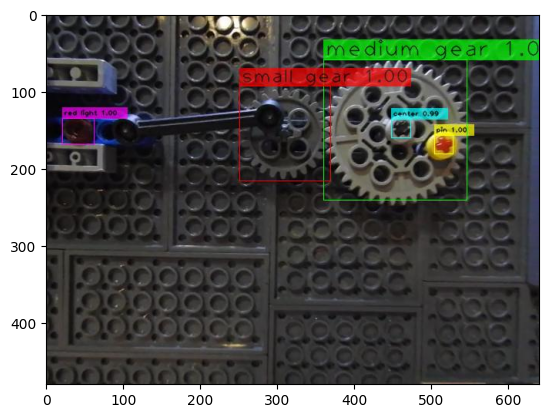

In [46]:
import cv2 as cv2
from matplotlib import pyplot as plt

%cd ~/nn/LegoGears/

!darknet detector test -dont_show LegoGears.data LegoGears.cfg LegoGears_best.weights set_01/DSCN1583_frame_000197.jpg
img = cv2.imread('predictions.jpg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))